In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import importlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from memoization import cached
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN , OPTICS
from sklearn.manifold import TSNE 
from sklearn import preprocessing
from utils import *
import utils


## Download Price yf_download

In [3]:
@cached
def yf_download(symbol, start, end):
    df = yf.download(symbol, start, end)[["Adj Close"]]
    return df
# AAPL = yf_download("AAPL", "2016-01-01", "2018-01-01")
# GOOG = yf_download("GOOG", "2016-01-01", "2018-01-01")

# Put ETF_5years.csv in your directory
etfs = pd.read_csv("ETF.csv").Symbol.tolist()
if os.path.exists("ETF_5years.csv"):
    Price = pd.read_csv("ETF_5years.csv", index_col=0)
else:
    Price = yf_download(etfs[0], "2017-01-01", "2022-01-01")
    Price.columns = [etfs[0]]
    for etf in etfs[1:]:
        Price_etf = yf_download(etf, "2017-01-01", "2022-01-01")
        Price_etf.columns = [etf]
        if len(Price_etf) < 1200:
            continue
        Price = Price.merge(Price_etf, left_index=True, right_index=True, how="left")
    Price.to_csv("ETF_5years.csv")

## OPTICS cluster

In [5]:
TRAIN_START = "2017-01-01"
TRAIN_END = "2020-01-01"
df_ret_train = Price.pct_change()[1:].loc[:TRAIN_END].copy()
# OPTICS_fit(df_returns)
labels = OPTICS_fit(normalize(df_ret_train))
# DBSCAN_fit(df_returns, 0.1, 4)
n_clusters_ = len(set(labels)) - 1
print("Clusters discovered:", n_clusters_)

clustered_series_all = pd.Series(index=df_ret_train.columns, data=labels)
# If it is -1, it means it is a seperate cluster with very few elements
clustered_series = clustered_series_all[clustered_series_all != -1]
# clustered_series
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts > 1)]
print("Pairs in group to evaluate:", (ticker_count_reduced * (ticker_count_reduced - 1)).sum() // 2)

Clusters discovered: 7
Pairs in group to evaluate: 176


## Visualize stock clusters using X_tsne

X_tsne Shape (98, 2)


<Figure size 1080x720 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'T-SNE of all Stocks with OPTICS Clusters Noted')

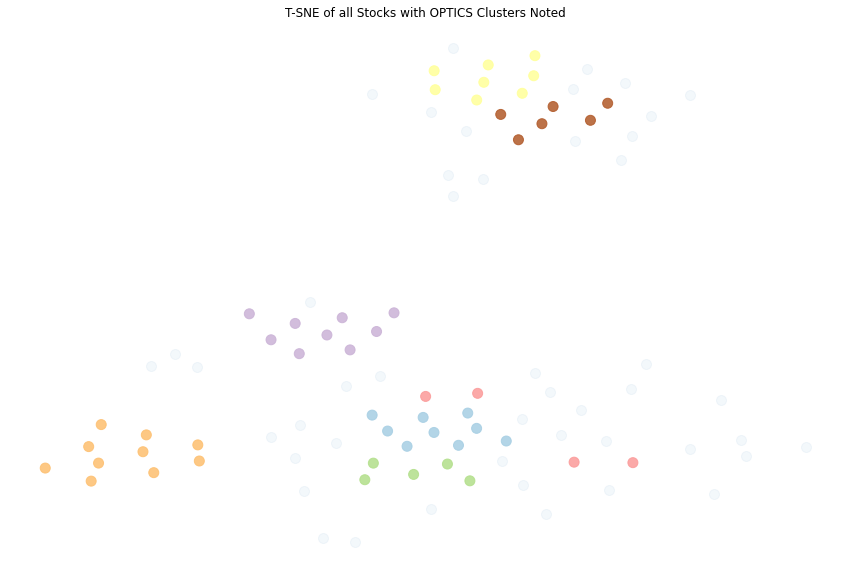

In [6]:
X_tsne = TSNE(learning_rate=1000, perplexity=25).fit_transform(normalize(df_ret_train).T)
print("X_tsne Shape", X_tsne.shape)
plt.figure(1, facecolor='white', figsize=(15,10))
plt.clf()
plt.axis('off')
# clustered
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)
# unclustered in the background
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)
plt.title('T-SNE of all Stocks with OPTICS Clusters Noted')
plt.show()

### Cluster Member Counts

<Figure size 864x504 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 1.0, 'Cluster Member Counts')

Text(0.5, 0, 'Stocks in Cluster')

Text(0, 0.5, 'Cluster Number')

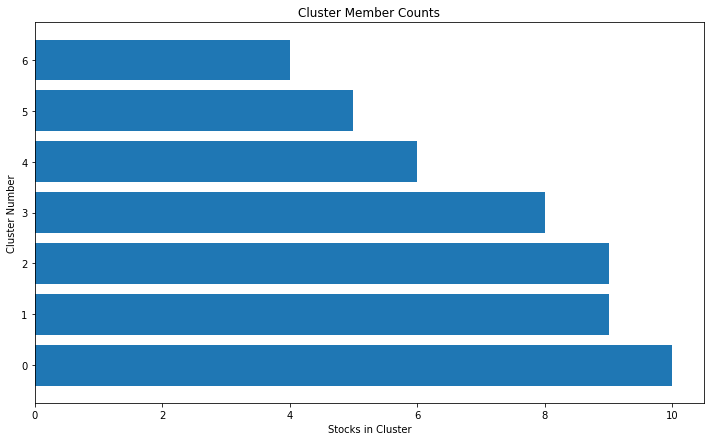

In [7]:
plt.figure(figsize=(12,7))
plt.barh(
range(len(clustered_series.value_counts())), # cluster labels, y axis 
      clustered_series.value_counts()
         )
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### Plot the stock price within same cluster

<AxesSubplot:title={'center':'Stock Time Series for Cluster 2'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 1'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 6'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 5'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 4'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 0'}, xlabel='Date'>

<AxesSubplot:title={'center':'Stock Time Series for Cluster 3'}, xlabel='Date'>

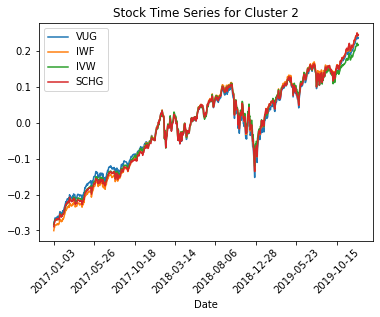

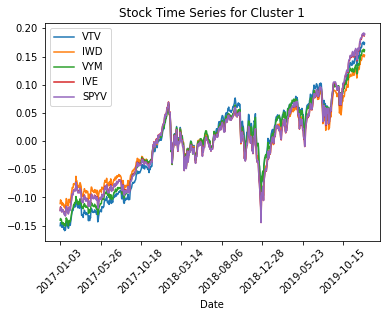

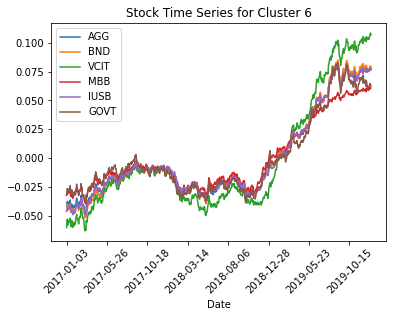

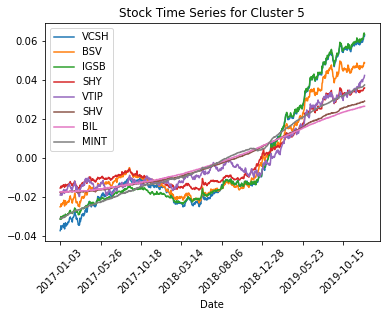

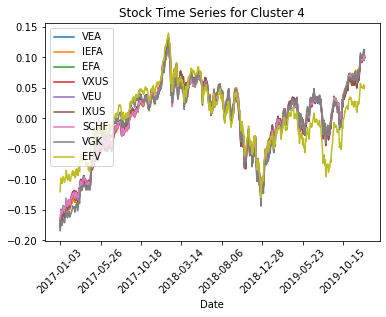

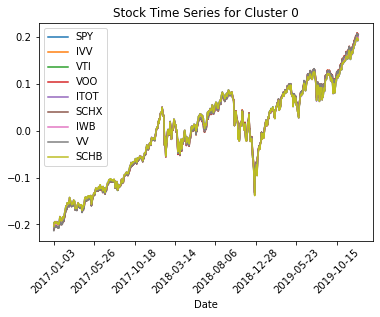

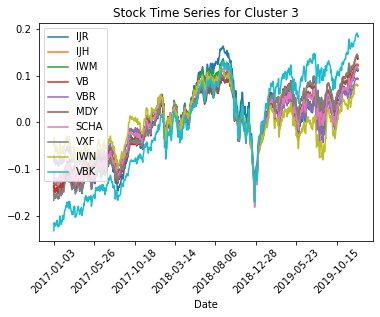

In [8]:
# get the number of stocks in each cluster 
counts = clustered_series.value_counts()
# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]
# plot a handful of the smallest clusters
for clust in cluster_vis_list: 
    tickers = list(clustered_series[clustered_series==clust].index) 
    means = np.log(Price.loc[:TRAIN_END, tickers].mean())
    this_data = np.log(Price.loc[:TRAIN_END, tickers]).sub(means) 
    this_data.plot(title='Stock Time Series for Cluster %d' % clust, rot=45)
    
plt.show()

## Calculate Cointegration
### Get p value of ADF test
if p is small, means the residual is stationary

In [10]:
significance = 0.05
start_day = TRAIN_START
end_day = TRAIN_END
E_selection = False
Opt_pairs = PairSelection(Price, ticker_count_reduced, clustered_series, significance, start_day, end_day, E_selection)

print("Number of clusters: ",len(ticker_count_reduced))
print("Number of cointegrated pairs: ",len(Opt_pairs))
print("Pairs with lowest p-value among all the clusters:")
Opt_pairs


Number of clusters:  7
Number of cointegrated pairs:  4
Pairs with lowest p-value among all the clusters:


[['VB', 'VXF'], ['SCHX', 'VV'], ['AGG', 'IUSB'], ['IVV', 'SCHX']]

Text(0.5, 0, 'O UN Equity')

Text(0, 0.5, 'VTR UN Equity')

Text(0.5, 0, 'AVA UN Equity')

Text(0, 0.5, 'UTL UN Equity')

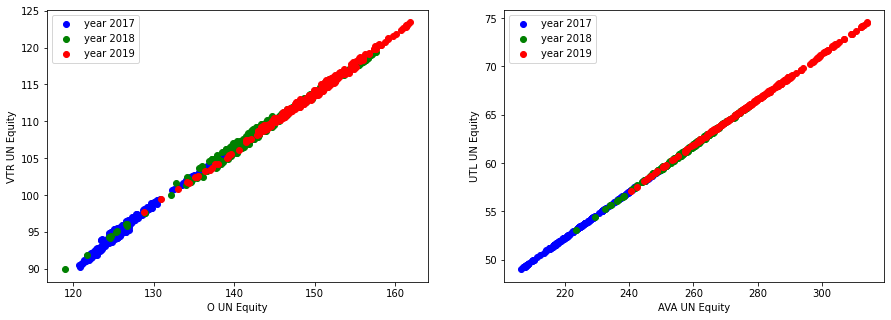

In [11]:
stock_VB = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[0][0]]
stock_VXF = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[0][1]]
stock_IVV = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[-1][0]]
stock_SCHX = Price.loc[TRAIN_START:TRAIN_END, Opt_pairs[-1][1]]
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))
ax1.set_xlabel("O UN Equity")
ax1.set_ylabel("VTR UN Equity")
ax1.scatter(stock_VB[0:252],stock_VXF[0:252], color='b',
            label = 'year 2017')
ax1.scatter(stock_VB[252:504],stock_VXF[252:504], color='g',
            label = 'year 2018')
ax1.scatter(stock_VB[504:756],stock_VXF[504:756], color='r',
            label = 'year 2019')
ax1.legend()
ax2.set_xlabel("AVA UN Equity")
ax2.set_ylabel("UTL UN Equity")
ax2.scatter(stock_IVV[0:252],stock_SCHX[0:252], color='b',
            label = 'year 2017')
ax2.scatter(stock_IVV[252:504],stock_SCHX[252:504], color='g',
            label = 'year 2018')
ax2.scatter(stock_IVV[504:756],stock_SCHX[504:756], color='r',
            label = 'year 2019')

ax2.legend()
plt.show()

## Bolling Band strategy


## ARIMA predict return

In [13]:
Price

,SPY,IVV,VTI,VOO,QQQ,VEA,IEFA,VTV,AGG,VWO,...,VMBS,IWS,SCZ,SHV,BIL,VTEB,SPYV,MINT,VBK,GDX
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,206.147537,206.448669,106.514442,188.826889,115.292564,31.734364,46.653103,82.195908,95.843132,31.678284,...,46.978447,73.160408,43.843433,104.629089,87.252800,45.289326,24.225023,93.324005,129.755371,20.845800
2017-01-04,207.373932,207.696915,107.330254,189.941193,115.919495,32.122734,47.154652,82.643608,95.869736,31.967310,...,46.960514,74.080879,44.324554,104.619621,87.252800,45.424793,24.363058,93.324005,131.975174,20.999077
2017-01-05,207.209183,207.505585,107.119431,189.795044,116.575294,32.407532,47.604324,82.336349,96.268425,32.300117,...,47.184849,73.746986,44.718208,104.610107,87.233727,45.578323,24.286369,93.342415,131.345093,22.225300
2017-01-06,207.950562,208.325653,107.458595,190.534851,117.597649,32.278091,47.422726,82.415344,95.949471,32.168743,...,47.086143,73.846237,44.613239,104.638603,87.252800,45.524128,24.332376,93.342415,131.190018,21.449329
2017-01-09,207.264099,207.651398,107.046082,189.932037,117.983437,32.200409,47.353542,81.967636,96.108917,32.116192,...,47.131004,73.214561,44.543251,104.657570,87.252800,45.569283,24.174631,93.360832,131.054291,21.516390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,477.260010,479.399994,242.960007,438.809998,403.480011,51.209999,74.750160,146.570007,114.095459,49.340000,...,52.750149,121.720001,72.816307,110.419998,91.430000,54.888092,41.820000,101.470955,283.399994,31.330000
2021-12-28,476.869995,479.029999,242.460007,438.480011,401.609985,51.209999,74.850014,146.940002,114.045532,49.169998,...,52.770130,121.989998,72.936211,110.410004,91.419998,54.898079,41.939999,101.470955,281.000000,31.090000
2021-12-29,477.480011,479.529999,242.600006,439.010010,401.549988,51.200001,74.860001,147.240005,113.706024,48.959999,...,52.690216,122.389999,73.175995,110.419998,91.419998,54.868114,42.040001,101.490936,281.440002,31.219999


## Use 20% and 80% quantile as lower and upper bound

## An simple strategy
Long when difference is larger than 2 * $\sigma$, close when it is smaller than $\sigma$

Short when difference is larger than 2 * $\sigma$, close when it is smaller than $\sigma$

In [12]:
def strategy_profit(df):

    df["Hedged"] = df.iloc[:,0] * get_hedgeRatio(df)
    df["dif"] = df["Hedged"] - df.iloc[:,1]
    mu = df['dif'][:252*3].mean()
    sigma = df['dif'][:252*3].std()

    money = 0
    long = False
    short = False
    lookback = 252 * 3
    transcation_cost = 0.005
    hists = []
    mu = df['dif'][:lookback].mean()
    u1, u2, d1, d2 = 1, 2, 1, 2

    for index, price in df["dif"][lookback:].iteritems():
        if price < mu - d2 * sigma and not long:
            long = True
            money -= price 
        if price > mu - d1 * sigma and long:
            long = False 
            money += price 
        if price > mu + u2 * sigma and not short:  
            short = True 
            money += price 
        if price < mu + u1 * sigma and short:
            short = False 
            money -= price 
        hists.append([index, price, long, short, money])
        
    if short:
        money -= price 
    if long:
        money += price 

    hists.append([index, price, False, False, money])

    print("Final money", round(money, 2))
    df_hist = pd.DataFrame(hists, columns=["date", "price_dif", "long", "short", "money"])

    def clean(x):
        return x if not np.isnan(x) else 0
    long_cost = clean(df_hist[df_hist["long"] == True]["price_dif"].mean())
    long_period = clean(df_hist[df_hist["long"] == True]["price_dif"].count())

    short_cost = clean(df_hist[df_hist["short"] == True]["price_dif"].mean())
    short_period = clean(df_hist[df_hist["short"] == True]["price_dif"].count())
    
    interest_cost = (abs(long_cost * long_period) + abs(short_cost * short_period)) / 252 * 0.05
    print("Cost of interest", interest_cost)
    return df_hist

## For example, we compare the first and second ETF

In [13]:
df = Price.iloc[:, [0,1]]
strategy_profit(df)

Final money 12.98
Cost of interest 0.0055376989065770155


,date,price_dif,long,short,money
0,2020-01-06,0.836909,False,False,0.000000
1,2020-01-07,0.811324,False,False,0.000000
2,2020-01-08,0.890932,False,False,0.000000
3,2020-01-09,0.906140,False,False,0.000000
4,2020-01-10,0.870543,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,0.867239,False,False,12.983208
500,2021-12-29,0.981127,False,False,12.983208
501,2021-12-30,1.002747,False,False,12.983208
502,2021-12-31,0.985119,False,False,12.983208


In [14]:
n = 10
for i in range(n):
    for j in range(i+1, n):
        strategy_profit(Price.iloc[:,[i,j]])

Final money 12.98
Cost of interest 0.0055376989065770155


,date,price_dif,long,short,money
0,2020-01-06,0.836909,False,False,0.000000
1,2020-01-07,0.811324,False,False,0.000000
2,2020-01-08,0.890932,False,False,0.000000
3,2020-01-09,0.906140,False,False,0.000000
4,2020-01-10,0.870543,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,0.867239,False,False,12.983208
500,2021-12-29,0.981127,False,False,12.983208
501,2021-12-30,1.002747,False,False,12.983208
502,2021-12-31,0.985119,False,False,12.983208


Final money 1.87
Cost of interest 0.235505745571093


,date,price_dif,long,short,money
0,2020-01-06,4.044245,False,True,4.044245
1,2020-01-07,3.962583,False,True,4.044245
2,2020-01-08,4.046295,False,True,4.044245
3,2020-01-09,4.159224,False,True,4.044245
4,2020-01-10,4.149640,False,True,4.044245
...,...,...,...,...,...
499,2021-12-28,6.299331,False,True,8.188714
500,2021-12-29,6.477547,False,True,8.188714
501,2021-12-30,6.178964,False,True,8.188714
502,2021-12-31,6.322982,False,True,8.188714


Final money 10.22
Cost of interest 0.007293662574591376


,date,price_dif,long,short,money
0,2020-01-06,1.029788,False,False,0.000000
1,2020-01-07,1.011371,False,False,0.000000
2,2020-01-08,1.065546,False,False,0.000000
3,2020-01-09,1.035011,False,False,0.000000
4,2020-01-10,1.028422,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,1.088651,False,False,10.221882
500,2021-12-29,1.120952,False,False,10.221882
501,2021-12-30,1.144218,False,False,10.221882
502,2021-12-31,1.238054,False,False,10.221882


Final money 33.4
Cost of interest 6.435430050321461


,date,price_dif,long,short,money
0,2020-01-06,138.587224,False,True,138.587224
1,2020-01-07,137.627499,False,True,138.587224
2,2020-01-08,137.894534,False,True,138.587224
3,2020-01-09,138.465743,False,True,138.587224
4,2020-01-10,137.997816,False,True,138.587224
...,...,...,...,...,...
499,2021-12-28,133.622559,False,False,33.404610
500,2021-12-29,134.367230,False,False,33.404610
501,2021-12-30,134.085653,False,False,33.404610
502,2021-12-31,135.238776,False,False,33.404610


Final money 2.83
Cost of interest 0.5440356271274088


,date,price_dif,long,short,money
0,2020-01-06,-19.625772,False,False,0.000000
1,2020-01-07,-19.621487,False,False,0.000000
2,2020-01-08,-19.561201,False,False,0.000000
3,2020-01-09,-19.581761,False,False,0.000000
4,2020-01-10,-19.503841,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-17.712261,False,False,2.830735
500,2021-12-29,-17.659412,False,False,2.830735
501,2021-12-30,-17.632137,False,False,2.830735
502,2021-12-31,-17.696432,False,False,2.830735


Final money 4.05
Cost of interest 0.8496457757202303


,date,price_dif,long,short,money
0,2020-01-06,-30.667181,False,False,0.000000
1,2020-01-07,-30.612895,False,False,0.000000
2,2020-01-08,-30.589008,False,False,0.000000
3,2020-01-09,-30.547217,False,False,0.000000
4,2020-01-10,-30.344258,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-27.343666,False,False,4.051422
500,2021-12-29,-27.292882,False,False,4.051422
501,2021-12-30,-27.234381,False,False,4.051422
502,2021-12-31,-27.323928,False,False,4.051422


Final money 12.15
Cost of interest 1.7146806924189886


,date,price_dif,long,short,money
0,2020-01-06,-40.057739,True,False,40.057739
1,2020-01-07,-39.827910,True,False,40.057739
2,2020-01-08,-39.703546,True,False,40.057739
3,2020-01-09,-39.726368,True,False,40.057739
4,2020-01-10,-39.560212,True,False,40.057739
...,...,...,...,...,...
499,2021-12-28,-35.382894,False,False,12.146595
500,2021-12-29,-35.540192,False,False,12.146595
501,2021-12-30,-35.658987,False,False,12.146595
502,2021-12-31,-35.999711,False,False,12.146595


Final money 6.69
Cost of interest 4.430128920554352


,date,price_dif,long,short,money
0,2020-01-06,-81.465787,False,False,0.000000
1,2020-01-07,-81.426369,False,False,0.000000
2,2020-01-08,-81.158276,False,False,0.000000
3,2020-01-09,-81.090231,False,False,0.000000
4,2020-01-10,-81.350970,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-73.040578,False,False,6.263133
500,2021-12-29,-72.648616,False,True,-66.385483
501,2021-12-30,-73.011762,False,True,-66.385483
502,2021-12-31,-73.075001,False,True,-66.385483


Final money 7.26
Cost of interest 0.5385073208884925


,date,price_dif,long,short,money
0,2020-01-06,-20.030712,False,False,0.000000
1,2020-01-07,-20.075015,False,False,0.000000
2,2020-01-08,-20.145959,False,False,0.000000
3,2020-01-09,-20.212077,False,False,0.000000
4,2020-01-10,-20.487355,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-14.886099,False,True,-8.050963
500,2021-12-29,-14.632244,False,True,-8.050963
501,2021-12-30,-15.357145,False,True,-8.050963
502,2021-12-31,-15.313417,False,True,-8.050963


Final money 2.8
Cost of interest 0.22317822322676273


,date,price_dif,long,short,money
0,2020-01-06,3.608303,False,True,3.608303
1,2020-01-07,3.539910,False,True,3.608303
2,2020-01-08,3.582345,False,True,3.608303
3,2020-01-09,3.687377,False,True,3.608303
4,2020-01-10,3.696251,False,True,3.608303
...,...,...,...,...,...
499,2021-12-28,5.846560,False,True,8.609734
500,2021-12-29,5.965737,False,True,8.609734
501,2021-12-30,5.655957,False,True,8.609734
502,2021-12-31,5.809120,False,True,8.609734


Final money 8.73
Cost of interest 0.001194500664405992


,date,price_dif,long,short,money
0,2020-01-06,0.263232,False,False,0.000000
1,2020-01-07,0.268250,False,False,0.000000
2,2020-01-08,0.249506,False,False,0.000000
3,2020-01-09,0.205042,False,False,0.000000
4,2020-01-10,0.231059,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,0.294325,False,False,8.727476
500,2021-12-29,0.222308,False,False,8.727476
501,2021-12-30,0.225772,False,False,8.727476
502,2021-12-31,0.335754,False,False,8.727476


Final money 33.68
Cost of interest 6.369183991486315


,date,price_dif,long,short,money
0,2020-01-06,137.628308,False,True,137.628308
1,2020-01-07,136.697188,False,True,137.628308
2,2020-01-08,136.875306,False,True,137.628308
3,2020-01-09,137.429381,False,True,137.628308
4,2020-01-10,137.001227,False,True,137.628308
...,...,...,...,...,...
499,2021-12-28,132.616495,False,False,33.675128
500,2021-12-29,133.234105,False,False,33.675128
501,2021-12-30,132.928526,False,False,33.675128
502,2021-12-31,134.101405,False,False,33.675128


Final money 2.81
Cost of interest 0.5464972573861647


,date,price_dif,long,short,money
0,2020-01-06,-19.688337,False,False,0.000000
1,2020-01-07,-19.682255,False,False,0.000000
2,2020-01-08,-19.627548,False,False,0.000000
3,2020-01-09,-19.649197,False,False,0.000000
4,2020-01-10,-19.568781,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-17.779110,False,False,2.806933
500,2021-12-29,-17.734217,False,False,2.806933
501,2021-12-30,-17.708434,False,False,2.806933
502,2021-12-31,-17.771482,False,False,2.806933


Final money 3.9
Cost of interest 0.8475729269732419


,date,price_dif,long,short,money
0,2020-01-06,-30.755977,False,False,0.000000
1,2020-01-07,-30.699142,False,False,0.000000
2,2020-01-08,-30.683166,False,False,0.000000
3,2020-01-09,-30.642921,False,False,0.000000
4,2020-01-10,-30.436421,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-27.438571,False,False,3.895318
500,2021-12-29,-27.399071,False,False,3.895318
501,2021-12-30,-27.342684,False,False,3.895318
502,2021-12-31,-27.430464,False,False,3.895318


Final money 12.17
Cost of interest 1.7276445055602037


,date,price_dif,long,short,money
0,2020-01-06,-40.253096,True,False,40.253096
1,2020-01-07,-40.017318,True,False,40.253096
2,2020-01-08,-39.911463,True,False,40.253096
3,2020-01-09,-39.937826,True,False,40.253096
4,2020-01-10,-39.763393,True,False,40.253096
...,...,...,...,...,...
499,2021-12-28,-35.585725,False,False,12.168194
500,2021-12-29,-35.769499,False,False,12.168194
501,2021-12-30,-35.893316,False,False,12.168194
502,2021-12-31,-36.229939,False,False,12.168194


Final money 6.68
Cost of interest 4.434286317078129


,date,price_dif,long,short,money
0,2020-01-06,-81.536462,False,False,0.000000
1,2020-01-07,-81.494859,False,False,0.000000
2,2020-01-08,-81.233565,False,False,0.000000
3,2020-01-09,-81.166814,False,False,0.000000
4,2020-01-10,-81.424513,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-73.113408,False,False,6.254718
500,2021-12-29,-72.731176,False,True,-66.476458
501,2021-12-30,-73.096173,False,True,-66.476458
502,2021-12-31,-73.157909,False,True,-66.476458


Final money 7.28
Cost of interest 0.5406624146943909


,date,price_dif,long,short,money
0,2020-01-06,-20.096167,False,False,0.000000
1,2020-01-07,-20.138627,False,False,0.000000
2,2020-01-08,-20.215287,False,False,0.000000
3,2020-01-09,-20.282529,False,False,0.000000
4,2020-01-10,-20.555248,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-14.956680,False,True,-8.116573
500,2021-12-29,-14.710970,False,True,-8.116573
501,2021-12-30,-15.437392,False,True,-8.116573
502,2021-12-31,-15.392383,False,True,-8.116573


Final money 5.08
Cost of interest 0.3882465839797993


,date,price_dif,long,short,money
0,2020-01-06,-6.127391,True,False,6.127391
1,2020-01-07,-6.001483,True,False,6.127391
2,2020-01-08,-6.095285,True,False,6.127391
3,2020-01-09,-6.325437,True,False,6.127391
4,2020-01-10,-6.315059,True,False,6.127391
...,...,...,...,...,...
499,2021-12-28,-10.058994,True,False,15.026494
500,2021-12-29,-10.341617,True,False,15.026494
501,2021-12-30,-9.790716,True,False,15.026494
502,2021-12-31,-9.951313,True,False,15.026494


Final money 40.07
Cost of interest 5.723149685757246


,date,price_dif,long,short,money
0,2020-01-06,132.294416,False,False,0.000000
1,2020-01-07,131.504684,False,False,0.000000
2,2020-01-08,131.603465,False,False,0.000000
3,2020-01-09,131.946779,False,False,0.000000
4,2020-01-10,131.492444,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,123.730405,False,False,40.072947
500,2021-12-29,124.093741,False,False,40.072947
501,2021-12-30,124.448707,False,False,40.072947
502,2021-12-31,125.280331,False,False,40.072947


Final money 2.59
Cost of interest 0.5600220286129355


,date,price_dif,long,short,money
0,2020-01-06,-19.895724,False,False,0.000000
1,2020-01-07,-19.881094,False,False,0.000000
2,2020-01-08,-19.830728,False,False,0.000000
3,2020-01-09,-19.864775,False,False,0.000000
4,2020-01-10,-19.786366,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-18.143052,False,False,2.590936
500,2021-12-29,-18.113961,False,False,2.590936
501,2021-12-30,-18.047150,False,False,2.590936
502,2021-12-31,-18.132164,False,False,2.590936


Final money 3.63
Cost of interest 0.8599715693593833


,date,price_dif,long,short,money
0,2020-01-06,-31.001857,False,False,0.000000
1,2020-01-07,-30.933014,False,False,0.000000
2,2020-01-08,-30.922958,False,False,0.000000
3,2020-01-09,-30.899993,False,False,0.000000
4,2020-01-10,-30.696481,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-27.881393,False,False,3.628636
500,2021-12-29,-27.864260,False,False,3.628636
501,2021-12-30,-27.749807,False,False,3.628636
502,2021-12-31,-27.868971,False,False,3.628636


Final money 9.97
Cost of interest 1.8586346765298178


,date,price_dif,long,short,money
0,2020-01-06,-41.294115,True,False,41.294115
1,2020-01-07,-41.029033,True,False,41.294115
2,2020-01-08,-40.939367,True,False,41.294115
3,2020-01-09,-41.009217,True,False,41.294115
4,2020-01-10,-40.840448,True,False,41.294115
...,...,...,...,...,...
499,2021-12-28,-37.330355,False,False,9.973872
500,2021-12-29,-37.567068,False,False,9.973872
501,2021-12-30,-37.553374,False,False,9.973872
502,2021-12-31,-37.961469,False,False,9.973872


Final money 3.09
Cost of interest 4.516261625197253


,date,price_dif,long,short,money
0,2020-01-06,-82.298619,False,False,0.0000
1,2020-01-07,-82.245346,False,False,0.0000
2,2020-01-08,-81.991871,False,False,0.0000
3,2020-01-09,-81.943481,False,False,0.0000
4,2020-01-10,-82.202155,False,False,0.0000
...,...,...,...,...,...
499,2021-12-28,-74.331560,False,False,3.0855
500,2021-12-29,-73.969121,False,False,3.0855
501,2021-12-30,-74.282643,False,False,3.0855
502,2021-12-31,-74.368819,False,False,3.0855


Final money 7.18
Cost of interest 0.4701402225278235


,date,price_dif,long,short,money
0,2020-01-06,-20.206951,False,False,0.000000
1,2020-01-07,-20.240903,False,False,0.000000
2,2020-01-08,-20.321507,False,False,0.000000
3,2020-01-09,-20.400802,False,False,0.000000
4,2020-01-10,-20.675872,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-15.174921,False,True,-8.431448
500,2021-12-29,-14.945293,False,True,-8.431448
501,2021-12-30,-15.629976,False,True,-8.431448
502,2021-12-31,-15.607936,False,True,-8.431448


Final money 32.78
Cost of interest 6.374250651623485


,date,price_dif,long,short,money
0,2020-01-06,137.671519,False,True,137.671519
1,2020-01-07,136.733287,False,True,137.671519
2,2020-01-08,136.936097,False,True,137.671519
3,2020-01-09,137.546829,False,True,137.671519
4,2020-01-10,137.085947,False,True,137.671519
...,...,...,...,...,...
499,2021-12-28,132.811937,False,False,32.780700
500,2021-12-29,133.517900,False,False,32.780700
501,2021-12-30,133.206538,False,False,32.780700
502,2021-12-31,134.243993,False,False,32.780700


Final money 2.87
Cost of interest 0.5470864558562876


,date,price_dif,long,short,money
0,2020-01-06,-19.706639,False,False,0.000000
1,2020-01-07,-19.700945,False,False,0.000000
2,2020-01-08,-19.644800,False,False,0.000000
3,2020-01-09,-19.663049,False,False,0.000000
4,2020-01-10,-19.584620,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-17.798865,False,False,2.867249
500,2021-12-29,-17.748482,False,False,2.867249
501,2021-12-30,-17.722969,False,False,2.867249
502,2021-12-31,-17.794405,False,False,2.867249


Final money 3.98
Cost of interest 0.8482091160642592


,date,price_dif,long,short,money
0,2020-01-06,-30.776252,False,False,0.00000
1,2020-01-07,-30.719981,False,False,0.00000
2,2020-01-08,-30.701938,False,False,0.00000
3,2020-01-09,-30.656831,False,False,0.00000
4,2020-01-10,-30.453167,False,False,0.00000
...,...,...,...,...,...
499,2021-12-28,-27.457936,False,False,3.98292
500,2021-12-29,-27.410639,False,False,3.98292
501,2021-12-30,-27.354662,False,False,3.98292
502,2021-12-31,-27.454360,False,False,3.98292


Final money 12.33
Cost of interest 1.7288079134404892


,date,price_dif,long,short,money
0,2020-01-06,-40.279308,True,False,40.279308
1,2020-01-07,-40.044915,True,False,40.279308
2,2020-01-08,-39.934095,True,False,40.279308
3,2020-01-09,-39.948891,True,False,40.279308
4,2020-01-10,-39.781178,True,False,40.279308
...,...,...,...,...,...
499,2021-12-28,-35.598612,False,False,12.327502
500,2021-12-29,-35.764034,False,False,12.327502
501,2021-12-30,-35.888905,False,False,12.327502
502,2021-12-31,-36.253609,False,False,12.327502


Final money 6.6
Cost of interest 4.370005204402479


,date,price_dif,long,short,money
0,2020-01-06,-81.538351,False,False,0.000000
1,2020-01-07,-81.497279,False,False,0.000000
2,2020-01-08,-81.234120,False,False,0.000000
3,2020-01-09,-81.163063,False,False,0.000000
4,2020-01-10,-81.423255,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-73.106351,False,False,6.161139
500,2021-12-29,-72.717359,False,True,-66.556220
501,2021-12-30,-73.082777,False,True,-66.556220
502,2021-12-31,-73.154867,False,True,-66.556220


Final money 7.28
Cost of interest 0.5410843102173383


,date,price_dif,long,short,money
0,2020-01-06,-20.112565,False,False,0.000000
1,2020-01-07,-20.155428,False,False,0.000000
2,2020-01-08,-20.230605,False,False,0.000000
3,2020-01-09,-20.294352,False,False,0.000000
4,2020-01-10,-20.569111,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-14.973346,False,True,-8.135762
500,2021-12-29,-14.722013,False,True,-8.135762
501,2021-12-30,-15.448722,False,True,-8.135762
502,2021-12-31,-15.412306,False,True,-8.135762


Final money 5.66
Cost of interest 0.9276777625486908


,date,price_dif,long,short,money
0,2020-01-06,-28.884640,False,False,0.000000
1,2020-01-07,-28.820209,False,False,0.000000
2,2020-01-08,-28.781035,False,False,0.000000
3,2020-01-09,-28.842340,False,False,0.000000
4,2020-01-10,-28.733615,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-27.177108,False,False,5.657693
500,2021-12-29,-27.170700,False,False,5.657693
501,2021-12-30,-27.122509,False,False,5.657693
502,2021-12-31,-27.252112,False,False,5.657693


Final money 5.55
Cost of interest 1.2235649336552008


,date,price_dif,long,short,money
0,2020-01-06,-43.835970,False,False,0.000000
1,2020-01-07,-43.696379,False,False,0.000000
2,2020-01-08,-43.702718,False,False,0.000000
3,2020-01-09,-43.719035,False,False,0.000000
4,2020-01-10,-43.472289,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-40.838029,False,False,5.554601
500,2021-12-29,-40.853097,False,False,5.554601
501,2021-12-30,-40.764720,False,False,5.554601
502,2021-12-31,-40.946444,False,False,5.554601


Final money 14.87
Cost of interest 3.295147995256526


,date,price_dif,long,short,money
0,2020-01-06,-70.895071,True,False,70.895071
1,2020-01-07,-70.464938,True,False,70.895071
2,2020-01-08,-70.410900,True,False,70.895071
3,2020-01-09,-70.569439,True,False,70.895071
4,2020-01-10,-70.300684,True,False,70.895071
...,...,...,...,...,...
499,2021-12-28,-66.908519,False,False,14.872669
500,2021-12-29,-67.220478,False,False,14.872669
501,2021-12-30,-67.269604,False,False,14.872669
502,2021-12-31,-67.827793,False,False,14.872669


Final money 9.74
Cost of interest 4.782256107877367


,date,price_dif,long,short,money
0,2020-01-06,-91.184774,False,False,0.000000
1,2020-01-07,-91.071955,False,False,0.000000
2,2020-01-08,-90.817569,False,False,0.000000
3,2020-01-09,-90.785616,False,False,0.000000
4,2020-01-10,-91.012840,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-81.586180,False,True,-72.024081
500,2021-12-29,-81.251521,False,True,-72.024081
501,2021-12-30,-81.598149,False,True,-72.024081
502,2021-12-31,-81.760259,False,True,-72.024081


Final money 9.84
Cost of interest 1.2679280295739739


,date,price_dif,long,short,money
0,2020-01-06,-29.195613,False,False,0.000000
1,2020-01-07,-29.178401,False,False,0.000000
2,2020-01-08,-29.268613,False,False,0.000000
3,2020-01-09,-29.373776,False,False,0.000000
4,2020-01-10,-29.618333,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-23.987048,False,True,-14.677719
500,2021-12-29,-23.780811,False,True,-14.677719
501,2021-12-30,-24.486057,False,True,-14.677719
502,2021-12-31,-24.512818,False,True,-14.677719


Final money 0.69
Cost of interest 0.017759156284209276


,date,price_dif,long,short,money
0,2020-01-06,-2.751527,False,False,0.000000
1,2020-01-07,-2.703449,False,False,0.000000
2,2020-01-08,-2.764946,True,False,2.764946
3,2020-01-09,-2.693661,True,False,2.764946
4,2020-01-10,-2.601488,True,False,2.764946
...,...,...,...,...,...
499,2021-12-28,-2.122814,False,False,0.689902
500,2021-12-29,-2.147000,False,False,0.689902
501,2021-12-30,-2.127417,False,False,0.689902
502,2021-12-31,-2.125823,False,False,0.689902


Final money 7.98
Cost of interest 0.1884738358881877


,date,price_dif,long,short,money
0,2020-01-06,23.479437,False,False,0.000000
1,2020-01-07,23.697893,False,False,0.000000
2,2020-01-08,23.619006,False,False,0.000000
3,2020-01-09,23.657204,False,False,0.000000
4,2020-01-10,23.570073,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,21.363442,False,False,7.975078
500,2021-12-29,21.030579,False,False,7.975078
501,2021-12-30,20.826201,False,False,7.975078
502,2021-12-31,20.700471,False,False,7.975078


Final money 15.53
Cost of interest 2.5773805353899033


,date,price_dif,long,short,money
0,2020-01-06,-39.260765,False,False,0.000000
1,2020-01-07,-39.255493,False,False,0.000000
2,2020-01-08,-39.036421,False,False,0.000000
3,2020-01-09,-38.868884,False,False,0.000000
4,2020-01-10,-39.286942,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-29.004557,False,False,15.533173
500,2021-12-29,-28.681653,False,False,15.533173
501,2021-12-30,-29.130568,False,False,15.533173
502,2021-12-31,-29.123834,False,False,15.533173


Final money 7.05
Cost of interest 0.10822827874599095


,date,price_dif,long,short,money
0,2020-01-06,1.784080,False,False,0.000000
1,2020-01-07,1.732644,False,False,0.000000
2,2020-01-08,1.602355,False,False,0.000000
3,2020-01-09,1.564345,False,False,0.000000
4,2020-01-10,1.203431,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,5.367026,False,True,11.969844
500,2021-12-29,5.566377,False,True,11.969844
501,2021-12-30,4.808581,False,True,11.969844
502,2021-12-31,4.917282,False,True,11.969844


Final money 8.36
Cost of interest 0.23102198198766277


,date,price_dif,long,short,money
0,2020-01-06,28.651235,False,False,0.000000
1,2020-01-07,28.761175,False,False,0.000000
2,2020-01-08,28.821859,False,False,0.000000
3,2020-01-09,28.691795,False,False,0.000000
4,2020-01-10,28.397034,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,24.830162,False,False,8.359278
500,2021-12-29,24.553077,False,False,8.359278
501,2021-12-30,24.307051,False,False,8.359278
502,2021-12-31,24.178211,False,False,8.359278


Final money 5.69
Cost of interest 2.672869920348094


,date,price_dif,long,short,money
0,2020-01-06,-50.279883,False,False,0.00000
1,2020-01-07,-50.298147,False,False,0.00000
2,2020-01-08,-50.039847,False,False,0.00000
3,2020-01-09,-49.994883,False,False,0.00000
4,2020-01-10,-50.453177,False,False,0.00000
...,...,...,...,...,...
499,2021-12-28,-43.736914,False,False,5.69127
500,2021-12-29,-43.388025,False,False,5.69127
501,2021-12-30,-43.816141,False,False,5.69127
502,2021-12-31,-43.804372,False,False,5.69127


Final money 6.78
Cost of interest 0.0971436447861692


,date,price_dif,long,short,money
0,2020-01-06,3.253149,False,False,0.000000
1,2020-01-07,3.167024,False,False,0.000000
2,2020-01-08,3.081487,False,False,0.000000
3,2020-01-09,2.988384,False,False,0.000000
4,2020-01-10,2.561170,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,6.240322,False,True,12.571907
500,2021-12-29,6.457714,False,True,12.571907
501,2021-12-30,5.687057,False,True,12.571907
502,2021-12-31,5.794850,False,True,12.571907


Final money 3.35
Cost of interest 4.103190063103123


,date,price_dif,long,short,money
0,2020-01-06,-70.410509,False,False,0.000000
1,2020-01-07,-70.441462,False,False,0.000000
2,2020-01-08,-70.227669,False,False,0.000000
3,2020-01-09,-70.168103,False,False,0.000000
4,2020-01-10,-70.477648,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-64.788580,False,False,3.349558
500,2021-12-29,-64.348506,False,False,3.349558
501,2021-12-30,-64.661840,False,False,3.349558
502,2021-12-31,-64.601780,False,False,3.349558


Final money 4.14
Cost of interest 0.13118116356268827


,date,price_dif,long,short,money
0,2020-01-06,-7.768290,False,False,0.000000
1,2020-01-07,-7.883038,False,False,0.000000
2,2020-01-08,-7.992315,False,False,0.000000
3,2020-01-09,-8.051641,False,False,0.000000
4,2020-01-10,-8.377821,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,-4.074606,False,False,3.599194
500,2021-12-29,-3.772537,False,True,-0.173343
501,2021-12-30,-4.460849,False,True,-0.173343
502,2021-12-31,-4.312435,False,True,-0.173343


Final money 12.34
Cost of interest 1.607169930439908


,date,price_dif,long,short,money
0,2020-01-06,30.789834,False,False,0.000000
1,2020-01-07,30.730949,False,False,0.000000
2,2020-01-08,30.455763,False,False,0.000000
3,2020-01-09,30.314378,False,False,0.000000
4,2020-01-10,30.228006,False,False,0.000000
...,...,...,...,...,...
499,2021-12-28,27.993853,False,False,12.341245
500,2021-12-29,27.974139,False,False,12.341245
501,2021-12-30,27.513047,False,False,12.341245
502,2021-12-31,27.616020,False,False,12.341245


In [15]:
# num_shares_google = 15
# google_price = df.iloc[0, 0]
# google_size = num_shares_google * google_price
# r = 0.0009

# aapl_price = df.iloc[0, 1]
# num_shares_aapl = np.around(-google_size/aapl_price) 
# aapl_size = aapl_price * num_shares_aapl
# initial_leverage = google_price

# google_size, aapl_size, initial_leverage

# delta_t = 1 / (2*252)
# equity = [100000]

# leverage = [initial_leverage]
# profits = [0]
# previous_googl = df.iloc[0, 0]
# previous_aapl = df.iloc[0, 1]
# one_lege_size = 25000